# Parallel Propagation of a conestellation of satellites and determining the shortest path between two satellites 

Project for High Performance Python Lab at Skoltech
By:
- Mohamed Sayed
- Koffivi
- Oluwafemi

In [ ]:
pip install poliastro;     # needed for conversion from orbital elemnts to cartesian ECEF(WGS84) coordinates 

In [ ]:
#importing and aliasing packages
import numpy as np
from scipy.integrate import solve_ivp       # solver used for propagation
import matplotlib.pyplot as plt
from poliastro.core.elements import coe2rv  # COnversion from orbital elements to cartesian ECEF(WGS84) coordinates 
import random
import time

**coe2rv**

params 
- k (float) – Standard gravitational parameter (km^3 / s^2).
- p (float) – Semi-latus rectum or parameter (km).
- ecc (float) – Eccentricity.
- inc (float) – Inclination (rad).
- raan (float) – Longitude of ascending node, omega (rad).
- argp (float) – Argument of perigee (rad).
- nu (f)

returns
- r_ijk (numpy.ndarray) – Position vector in basis ijk.
- v_ijk (numpy.ndarray) – Velocity vector in basis ijk.

In [ ]:
# creating parameter structures
class Parameters(object):
    pass

cnst = Parameters()
cnst.mu = 3.986e5
cnst.re = 6371
cnst.J2 = 0.00108263
cnst.m2km = 1e-3
cnst.SunP = 4.56e-6 / cnst.m2km**2 #unit N/km^2
cnst.ecenter = np.array([0.,0.,0.])

altitude = 600
inclination = 52 * np.pi / 180

T0 = 0
Tf = 1

# J2 effects

Taking into account the second zonal harmonic of geopotential

$$\ddot{\mathbf{r}} = \frac{3}{2}\frac{J_{2}\mu R^{2}}{r^{4}}\left [\frac{x}{r}\left ( 5\frac{z^{2}}{r^{2}}-1 \right )\vec{i} + \frac{y}{r}\left ( 5\frac{z^{2}}{r^{2}}-1 \right )\vec{j} + \frac{z}{r}\left ( 5\frac{z^{2}}{r^{2}}-3 \right )\vec{k}\right]$$

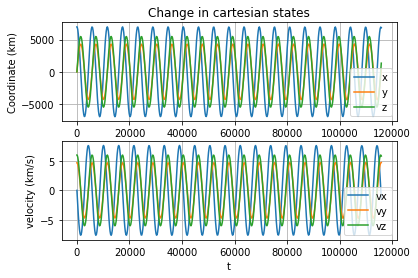

In [ ]:
def J2(r):
    r0 = np.linalg.norm(r)
    r2 = r0**2
    r5 = r0**5
    z2r2 = r[2]**2 /r2
    
    J2 = (1.5 * cnst.J2 * cnst.mu * cnst.re**2 * 
                        np.array([r[0]*(5 * z2r2 - 1), r[1]*(5 * z2r2 - 1), r[2]*(5 * z2r2 - 3)]) / r5)
    return J2

def rhs(t, x):
    v = x[3:]
    r = x[0:3]
    
    dxdt = np.zeros(6)    
    dxdt[0:3] = v
    dxdt[3:] = -cnst.mu * r / np.linalg.norm(r) ** 3 + J2(r)
    
    return dxdt

class satellite:
  def __init__(self, id, altitude, inc, ecc, raan, argp, nu):
    self.id = id
    self.altitude = altitude
    self.inc = inc
    self.orb_rad = cnst.re + altitude
    self.ecc = ecc
    self.raan = raan
    self.argp = argp
    self.nu = nu
    rv = coe2rv(cnst.mu, self.orb_rad, ecc ,inc, raan, argp, nu) 
    self.rv = np.concatenate((rv[0,:],rv[1,:]))
    self.r = rv[0,:]
    self.v = rv[1,:]
    self.x = self.r[0]
    self.y = self.r[1]
    self.z = self.r[2]

sat0 = satellite(0, altitude, inclination, 0., 0., 0., 0.)

t0 = 0
tf =20* 2 * np.pi * np.sqrt(sat0.orb_rad**3/cnst.mu)  # period 

# Propagation in time
sol0 = solve_ivp(rhs, (t0, tf), sat0.rv, method='DOP853', rtol = 1e-10, atol = 1e-10)
sol = sol0.y.T
t = sol0.t.T

# Plot the solution...
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t, sol[:,0], label='x')
ax.plot(t, sol[:,1], label='y')
ax.plot(t, sol[:,2], label='z')
plt.title('Change in cartesian states')
plt.ylabel('Coordinate (km)')
plt.grid(True)
plt.legend()

ax = fig.add_subplot(212)
ax.plot(t, sol[:,3], label='vx')
ax.plot(t, sol[:,4], label='vy')
ax.plot(t, sol[:,5], label='vz')
plt.ylabel('velocity (km/s)')
plt.xlabel('t')
plt.grid(True)
plt.legend()
plt.show()

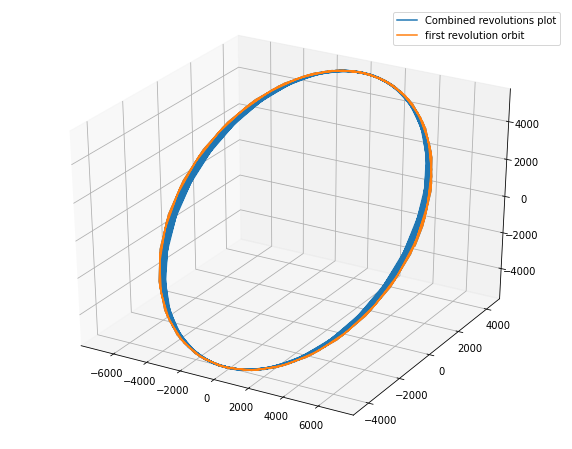

In [ ]:
# Orbit demonesteration
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol[:,0], sol[:,1], sol[:,2], label='Combined revolutions plot')
ax.plot(sol[0:100,0], sol[0:100,1], sol[0:100,2], label='first revolution orbit')
plt.legend()
plt.show()

# Creating conestellation (Walker-Star)
- symmetric
- T total no. of satellites
- S satellites evenly distributed in each of P orbital planes
- d_Omega ascending Nodes of the P orbital planes are uniformly 
distributed about the equator (Walker Delta – over 360 deg, 
Walker Star – over 180 deg)
- Within each plane, the S satellites are uniformly distributed in 
the orbit
- F relative phase between satellites in adjacent planes to avoid 
collisions

In [ ]:
def walkerDelta(sat0, T,P,F):
    s = T/P             # Number of satellites per plane
    d_nu = 2*np.pi / s      # In plane spacing between satellites
    d_raan = np.pi / P    # Node spacing 180
    d_phase = 2*np.pi /(s*P)  # Phase difference between adjacent planes
    
    raan_arr_0orbit = np.arange(sat0.raan, sat0.raan+np.pi, d_raan) #180
    raan_arr = np.repeat(raan_arr_0orbit, s)
    nu_arr = np.arange(sat0.nu, sat0.nu+2*np.pi, d_nu)
    for i in range(1,P):
        nu_arr_iorbit = np.arange(sat0.nu + d_phase*i, sat0.nu+2*np.pi, d_nu)
        nu_arr = np.concatenate((nu_arr, nu_arr_iorbit))
    sats = []
    for j in range(T):
        sats.append(satellite(j, sat0.altitude,sat0.inc, sat0.ecc, raan_arr[j], sat0.argp, nu_arr[j]))
    
    return sats

## Constellation parameters

In [ ]:
T = 600; P = 12; F = 1    # Conestallation parameters 
sats = walkerDelta(sat0, T,P,F)  # Creating the satellites' objects 

In [ ]:
t0 = 0
tf = 2 * np.pi * np.sqrt(sats[0].orb_rad**3/cnst.mu)  # One orbit period 

# Propagation in time
sol_sub = []
t = []
for i, sat in enumerate(sats):
    print(i)
    sol = solve_ivp(rhs, (t0, tf), sat.rv, method='DOP853', rtol = 1e-10, atol = 1e-10)
    sol_sub.append(sol.y.T)   # satellite ID and it's cartesian coordinates x,y,z
    t.append(sol.t.T)     # Time steps

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

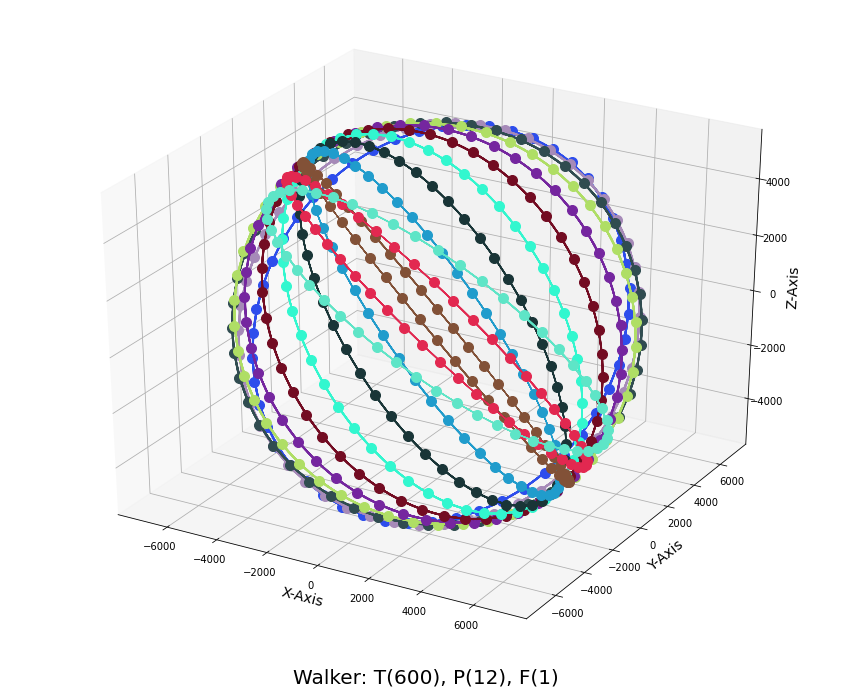

In [ ]:
# Plotting
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

#all_colrs = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
choosen_colors = np.random.rand(P,3); #np.random.shuffle(choosen_colors)
point_colors = np.repeat(choosen_colors, T/P, axis=0)
for i, sol in enumerate(sol_sub):
    ax.plot(sol[0:100,0], sol[0:100,1], sol[0:100,2], color = point_colors[i], linewidth=0.5, linestyle='-')
    ax.plot([sol[0,0]], [sol[0,1]], [sol[0,2]], markerfacecolor=point_colors[i], markeredgecolor=point_colors[i], marker='o', markersize=10)
    
ax.set_xlabel('X-Axis', fontsize =14)
ax.set_ylabel('Y-Axis', fontsize =14)
ax.set_zlabel('Z-Axis', fontsize =14, rotation=90)
ax.set_title('Walker: T('+str(T)+'), P('+str(P)+'), F('+str(F)+')', fontsize = 20, y=-0.05)
plt.show()

# Determining the shortest path

In [ ]:
from scipy.spatial import distance
import sys   

ecenter = cnst.ecenter
def check_intersection_with_earth(sat1, sat2, ecenter):  # ecenter = basicaly center of the earth (0,0,0)

    # More info here -->  http://paulbourke.net/geometry/circlesphere/

    a = (sat2.x -sat1.x)**2 + (sat2.y -sat1.y)**2 +(sat2.z -sat1.z)**2
    b = 2*((sat2.x - sat1.x)*(sat1.x - ecenter[0]) + (sat2.y -sat1.y)*(sat1.y -ecenter[1]) + (sat2.z -sat1.z)*(sat1.z -ecenter[2]))
    c = ecenter[0]**2 + ecenter[1]**2 + ecenter[2]**2 + sat1.x**2 + sat1.y**2 + sat1.z**2 -2*(ecenter[0]*sat1.x + ecenter[1]*sat1.y + ecenter[2]*sat1.z) - cnst.re**2
    delta = b*b - 4*a*c
    if sat1.id == sat2.id:
      return False
    elif delta >= 0:
        return True  #the line intersects the earth at two points or is tangent to the earth
    else:
        return False # no intersection between the line and the earth

    
def distance_btw2_sat(sat1,sat2):
    return distance.cdist([sat1.r],[sat2.r], metric='euclidean')

def Initialisation(graph,source_sat):     # graph is just a list of all satelites
    print(distance_btw2_sat(source_sat, sat))
    node_data = {sat.id:{'cost':distance_btw2_sat(source_sat, sat) , 'pred':source_sat.id} for  sat in graph}    
    node_data[source_sat.id]['cost'] = 0
    return node_data

def id2sat(graph, sat_id):
    for sat in graph:
        if sat.id == sat_id:
            break
    return sat

In [ ]:
import sys
def dijkstra_algorithm(graph, start_node):
    unvisited_nodes = list(graph.get_nodes())
 
    # We'll use this dict to save the cost of visiting each node and update it as we move along the graph   
    shortest_path = {}
 
    # We'll use this dict to save the shortest known path to a node found so far
    previous_nodes = {}
 
    # We'll use max_value to initialize the "infinity" value of the unvisited nodes   
    max_value = sys.maxsize
    for node in unvisited_nodes:
        shortest_path[node] = max_value
    # However, we initialize the starting node's value with 0   
    shortest_path[start_node] = 0
    
    # The algorithm executes until we visit all nodes
    while unvisited_nodes:
        # The code block below finds the node with the lowest score
        current_min_node = None
        for node in unvisited_nodes: # Iterate over the nodes
            if current_min_node == None:
                current_min_node = node
            elif shortest_path[node] < shortest_path[current_min_node]:
                current_min_node = node
                
        # The code block below retrieves the current node's neighbors and updates their distances
        neighbors = graph.get_outgoing_edges(current_min_node)
        for neighbor in neighbors:
            tentative_value = shortest_path[current_min_node] + graph.value(current_min_node, neighbor)
            if tentative_value < shortest_path[neighbor]:
                shortest_path[neighbor] = tentative_value
                # We also update the best path to the current node
                previous_nodes[neighbor] = current_min_node
 
        # After visiting its neighbors, we mark the node as "visited"
        unvisited_nodes.remove(current_min_node)
    
    return previous_nodes, shortest_path

class Graph:
    def __init__(self, nodes, init_graph):
        self.nodes = nodes
        #self.graph = init_graph
        self.graph = self.construct_graph(nodes, init_graph)
        
    def construct_graph(self, nodes, init_graph):
        '''
        This method makes sure that the graph is symmetrical. In other words, if there's a path from node A to B with a value V, there needs to be a path from node B to node A with a value V.
        '''
        graph = {}
        for node in nodes:
            graph[node] = {}
        
        graph.update(init_graph)
        
        for node, edges in graph.items():
            for adjacent_node, value in edges.items():
                if graph[adjacent_node].get(node, False) == False:
                    graph[adjacent_node][node] = value
                    
        return graph
       
    
    def get_nodes(self):
        "Returns the nodes of the graph."
        return self.nodes
    
    def get_outgoing_edges(self, node):
        "Returns the neighbors of a node."
        connections = []
        #print('check-2: ', node)
        #print('check-1: ', self.graph[node])
        for out_node in self.nodes:
            #print('check0: ',self.graph[node], out_node )
            #print('check: ', self.graph[node].get(out_node, False))
            if self.graph[node].get(out_node, False) != False:
                connections.append(out_node)
        return connections
    
    def value(self, node1, node2):
        "Returns the value of an edge between two nodes."
        return self.graph[node1][node2]

def print_result(previous_nodes, shortest_path, start_node, target_node):
    path = []
    node = target_node
    
    while node != start_node:
        path.append(node)
        node = previous_nodes[node]
 
    # Add the start node manually
    path.append(start_node)
    
    print("We found the following best path with a value of {}.".format(shortest_path[target_node]))
    print(" -> ".join(reversed(path)))
    return reversed(path)

In [ ]:
nodes = []
for sat in sats:
    nodes.append(str(sat.id))


init_graph = {}
for node in nodes:
    init_graph[node] = {}

for node in nodes:
    source_sat = id2sat(sats, int(node))
    for dest_node in nodes:
        if node == dest_node: 
            continue
        else:
            dest_sat = id2sat(sats, int(dest_node))
            if check_intersection_with_earth(source_sat,dest_sat,ecenter)==False:
                init_graph[node][dest_node] = int(distance_btw2_sat(source_sat,dest_sat)[0][0])

#print(init_graph)
graph = Graph(nodes, init_graph)
previous_nodes, shortest_path = dijkstra_algorithm(graph=graph, start_node="0")
reversed_path = list(print_result(previous_nodes, shortest_path, start_node="0", target_node=random.choice(nodes)))

We found the following best path with a value of 11375.
0 -> 103 -> 204 -> 254


In [ ]:
reversed_path

['0', '103', '204', '254']

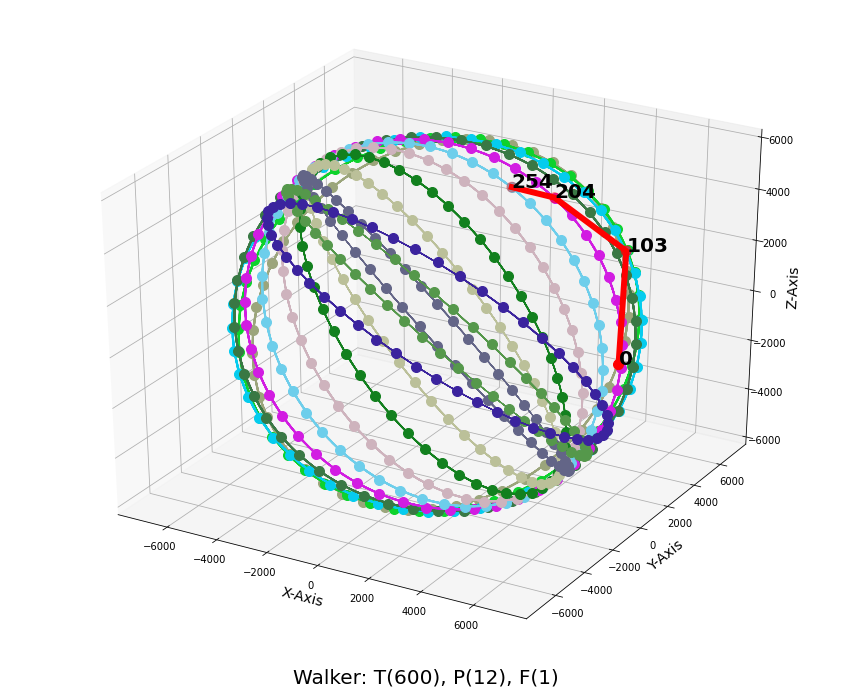

In [ ]:
# Plotting
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

choosen_colors = np.random.rand(P,3); 
point_colors = np.repeat(choosen_colors, T/P, axis=0)
#ax.scatter(0,0,0, color='gray', s=6371*4)

for i, sol in enumerate(sol_sub):
    ax.plot(sol[0:100,0], sol[0:100,1], sol[0:100,2], color = point_colors[i], linewidth=0.5, linestyle='-')
    ax.plot([sol[0,0]], [sol[0,1]], [sol[0,2]], markerfacecolor=point_colors[i], markeredgecolor=point_colors[i], marker='o', markersize=10)
xl = []
yl = []
zl = []
for id in reversed_path:
    sat = id2sat(sats, int(id))
    xl.append(sat.x)
    yl.append(sat.y)
    zl.append(sat.z)
    ax.text(sat.x, sat.y, sat.z, str(sat.id), fontsize=20 ,fontweight='bold', horizontalalignment='left')

ax.scatter(xl,yl,zl, color='red', s=100)
ax.plot(xl, yl, zl, color='red', linewidth=6)
ax.set_xlabel('X-Axis', fontsize =14)
ax.set_ylabel('Y-Axis', fontsize =14)
ax.set_zlabel('Z-Axis', fontsize =14, rotation=90)
ax.set_title('Walker: T('+str(T)+'), P('+str(P)+'), F('+str(F)+')', fontsize = 20, y=-0.05)

plt.show()

# Timing 1 step propagation



In [ ]:
conestallations_params= np.array([[10,5,1], [25,5,1], [50,5,1], [100,5,1], [200,8,1], [300,10,1], [400,10,1], [500,10,1], [600,12,1], [4000,20,1]])
conestallations = []
for param in conestallations_params:
    conestallations.append(walkerDelta(sat0, param[0],param[1],param[1])) # Creating the satellites' objects 

t0 = 0
tf = 1
#tf = 2 * np.pi * np.sqrt(sats[0].orb_rad**3/cnst.mu)  # One orbit period 

# Propagation in time
T_cpu = []
for i, sats in enumerate(conestallations):
    s = time.time()
    #print('i: ', i)
    sol_sub = []
    for sat in sats:
        sol = solve_ivp(rhs, (t0, 20*tf), sat.rv, method='DOP853', rtol = 1e-10, atol = 1e-10)
        sol_sub.append(sol.y.T)   # satellite ID and it's cartesian coordinates x,y,z
    T_cpu.append(time.time() - s)
print(T_cpu)

[0.02268075942993164, 0.04628634452819824, 0.09887170791625977, 0.19340801239013672, 0.39261794090270996, 0.7962234020233154, 0.8199582099914551, 1.082460880279541, 1.208446979522705, 7.913645029067993]


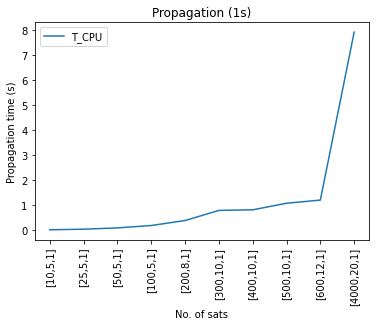

In [ ]:
labels = ['[10,5,1]', '[25,5,1]', '[50,5,1]', '[100,5,1]', '[200,8,1]', '[300,10,1]', '[400,10,1]', '[500,10,1]', '[600,12,1]', '[4000,20,1]']
plt.plot(np.arange(len(conestallations)),T_cpu, label = "T_CPU")
plt.xticks(np.arange(len(conestallations)), labels, rotation ='vertical')
#plt.plot(np.arange(20, 200, 20),T_GPU, label = "T_GPU")
plt.title("Propagation (1s)")
plt.xlabel("No. of sats"); plt.ylabel("Propagation time (s)")
plt.legend()
plt.show()

# Now making it parallel using mpi4py

In [ ]:
pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438361 sha256=895ca5ccfbb1d5cc5e16dbbfe0d1862765b83dc2db8936e783149d42e12cdfb0
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [ ]:
from mpi4py import MPI

In [ ]:
%%writefile Parallel_propagation.py
#!/usr/local/bin/python

import numpy as np
from scipy.integrate import solve_ivp
from poliastro.core.elements import coe2rv
import pickle
import random
import time

from mpi4py import MPI
import sys

T = int(sys.argv[1])
P = int(sys.argv[2])
F = int(sys.argv[3])
I = int(sys.argv[4])
t0 = 0
tf = 1

# creating parameter structures
class Parameters(object):
    pass

cnst = Parameters()
cnst.mu = 3.986e5
cnst.re = 6371
cnst.J2 = 0.00108263
cnst.m2km = 1e-3
cnst.SunP = 4.56e-6 / cnst.m2km**2 #unit N/km^2

def J2(r):
    r0 = np.linalg.norm(r)
    r2 = r0**2
    r5 = r0**5
    z2r2 = r[2]**2 /r2
    
    J2 = (1.5 * cnst.J2 * cnst.mu * cnst.re**2 * 
                        np.array([r[0]*(5 * z2r2 - 1), r[1]*(5 * z2r2 - 1), r[2]*(5 * z2r2 - 3)]) / r5)
    return J2

def rhs(t, x):
    v = np.array(x[3:])
    r = np.array(x[0:3])   
    dxdt = np.zeros(6)    
    dxdt[0:3] = v
    dxdt[3:] = -cnst.mu * r / np.linalg.norm(r) ** 3 + J2(r)   
    return dxdt

class satellite:
  def __init__(self, id, altitude, inc, ecc, raan, argp, nu):
    self.id = id
    self.altitude = altitude
    self.inc = inc
    self.orb_rad = cnst.re + altitude
    self.ecc = ecc
    self.raan = raan
    self.argp = argp
    self.nu = nu
    rv = coe2rv(cnst.mu, self.orb_rad, ecc ,inc, raan, argp, nu) 
    self.rv = np.concatenate((rv[0,:],rv[1,:]))
  
def walkerDelta(sat0, T,P,F):
    s = T/P             # Number of satellites per plane
    d_nu = 2*np.pi / s      # In plane spacing between satellites
    d_raan = np.pi / P    # Node spacing 180
    d_phase = 2*np.pi /(s*P)  # Phase difference between adjacent planes
    raan_arr_0orbit = np.arange(sat0.raan, sat0.raan+np.pi, d_raan) #180
    raan_arr = np.repeat(raan_arr_0orbit, s)
    nu_arr = np.arange(sat0.nu, sat0.nu+2*np.pi, d_nu)
    for i in range(1,P):
        nu_arr_iorbit = np.arange(sat0.nu + d_phase*i, sat0.nu+2*np.pi, d_nu)
        nu_arr = np.concatenate((nu_arr, nu_arr_iorbit))
    sats = []
    for j in range(T):
        sats.append(satellite(j, sat0.altitude,sat0.inc, sat0.ecc, raan_arr[j], sat0.argp, nu_arr[j]))    
    return sats


altitude = 400
inclination = 52 * np.pi / 180
sat0 = satellite(0, altitude, inclination, 0., 0., 0., 0.)
sats = walkerDelta(sat0, T,P,F)  

T_mpi = []
t1 = time.time()
#-------------------------------------------------------------------------------
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

sats_sub = np.array_split(sats, size)[rank]
# Propagation in time
#sol_ids_sub = []
sol_sub = []
for sat in sats_sub:
    sol = solve_ivp(rhs, (t0, 20*tf), sat.rv, method='DOP853', rtol = 1e-10, atol = 1e-10)
    #sol_ids_sub.append([sat.id, sol.y.T])    # Sat id and cartesian coordinates x,y,z
    sol_sub.append(sol.y.T)     # Cartesian coordinates x,y,z

if rank == 0:
    SOL = []

sol_sub_temp = comm.gather(sol_sub, root=0)

if rank == 0:
    SOL.append(sol_sub_temp)
    print("after: good...saving")
    t2 = time.time()
    T_mpi.append(t2-t1)
    with open('SOL'+str(I)+'mat', 'wb') as fp:
        pickle.dump([SOL, T_mpi], fp)

Overwriting Parallel_propagation.py


In [ ]:
!chmod +x Parallel_propagation.py
T_mpi = []
for i, param in enumerate(conestallations_params):
    print('i: ', i)
    t1 = time.time()
    !mpirun --allow-run-as-root -n 2 Parallel_propagation.py {param[0]} {param[1]} {param[2]} {i}
    t2 = time.time()
    print('t: ', t2-t1)
    T_mpi.append(t2-t1)

In [ ]:
import pickle

T_MPI = []
for I in range(len(conestallations_params)):
    I = str(I)
    with open ('SOL'+I+'mat', 'rb') as fp:
        SOL = pickle.load(fp)
        #print(SOL)
        T_MPI.append(SOL[1])

In [ ]:
T_MPI

[[0.1003119945526123],
 [0.04099416732788086],
 [0.07901978492736816],
 [0.23264384269714355],
 [0.387310266494751],
 [0.6485724449157715],
 [0.8222341537475586],
 [0.995530366897583],
 [1.2841796875],
 [1.9602181911468506],
 [4.102346897125244]]

In [ ]:
## rearanging the list
SOL2 = []
for thread in SOL:
    for sat_sol in thread:
        SOL2.extend(sat_sol)

In [ ]:
# Plotting
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

#all_colrs = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
choosen_colors = np.random.rand(P,3)
point_colors = aan_arr = np.repeat(choosen_colors, T/P, axis=0)
for i, sol in enumerate(SOL2):
    ax.plot(sol[0:100,0], sol[0:100,1], sol[0:100,2], color = point_colors[i], linewidth=0.5, linestyle='-')
    ax.plot([sol[0,0]], [sol[0,1]], [sol[0,2]], markerfacecolor=point_colors[i], markeredgecolor=point_colors[i], marker='o', markersize=10)
    
ax.set_xlabel('X-Axis', fontsize =14)
ax.set_ylabel('Y-Axis', fontsize =14)
ax.set_zlabel('Z-Axis', fontsize =14, rotation=90)
plt.show()

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

# Now with Numba

also refrence for numblsoda dop853 integrator can be found here: https://pypi.org/project/numbalsoda/

and for the simple rk4 integrator it's by Lutz Lehmann: here https://stackoverflow.com/questions/69425978/solve-odes-with-numba

In [ ]:
pip install numbalsoda

In [ ]:
from numba import njit, int32, float32, float64, objmode, cfunc
from numba.experimental import jitclass
from numbalsoda import lsoda, lsoda_sig, dop853

In [ ]:
mu = cnst.mu
re = cnst.re
j2 = cnst.J2

In [ ]:
spec = [
    ('id', int32),               
    ('altitude', float32),
    ('inc', float32),
    ('orb_rad', float32),  
    ('ecc', float32),  
    ('raan', float32),  
    ('argp', float32),  
    ('nu', float32),
    ('rv', float64[:]), 
    ('r', float64[:]), 
    ('v', float64[:]), 
    ('x', float32),
    ('y', float32),
    ('z', float32)
]

@jitclass(spec)
class satellite_Numba:
    def __init__(self, id, altitude, inc, ecc, raan, argp, nu):
        self.altitude = altitude
        self.inc = inc
        self.orb_rad = re + altitude
        self.ecc = ecc
        self.raan = raan
        self.argp = argp
        self.nu = nu
        self.rv = coe2rv(mu, self.orb_rad, self.ecc ,self.inc, self.raan, self.argp, self.nu).reshape((1,6))[0] 
        self.r = self.rv[0:3]
        self.v = self.rv[3:]
        self.x = self.r[0]
        self.y = self.r[1]
        self.z = self.r[2]
    
@njit
def walkerDelta_Numba(sat0, T,P,F):
    s = int(T/P)             # Number of satellites per plane
    d_nu = 2*np.pi / s      # In plane spacing between satellites
    d_raan = np.pi / P    # Node spacing 180
    d_phase = 2*np.pi /(s*P)  # Phase difference between adjacent planes
    
    raan_arr_0orbit = np.arange(sat0.raan, sat0.raan+np.pi, d_raan) #180
    raan_arr = np.repeat(raan_arr_0orbit, s)
    nu_arr = np.arange(sat0.nu, sat0.nu+2*np.pi, d_nu)
    for i in range(1,P):
        nu_arr_iorbit = np.arange(sat0.nu + d_phase*i, sat0.nu+2*np.pi, d_nu)
        nu_arr = np.concatenate((nu_arr, nu_arr_iorbit))
    sats = []
    for j in range(T):
        sats.append(satellite_Numba(j, sat0.altitude,sat0.inc, sat0.ecc, raan_arr[j], sat0.argp, nu_arr[j]))
    
    return sats   

In [ ]:
@njit
def J2_Numba(r):
    r0 = np.linalg.norm(r)
    r2 = r0**2
    r5 = r0**5
    z2r2 = r[2]**2 /r2
    
    J2 = (1.5 * j2 * mu * re**2 * 
                        np.array([r[0]*(5 * z2r2 - 1), r[1]*(5 * z2r2 - 1), r[2]*(5 * z2r2 - 3)]) / r5)
    return J2

@njit
def rhs_Numba(t, x):
    v = x[3:]
    r = x[0:3]
    
    dxdt = np.zeros(6)    
    dxdt[0:3] = v
    dxdt[3:] = -mu* r / np.linalg.norm(r) ** 3 + J2_Numba(r)
    
    return dxdt

@njit
def rungeStep(f, t, y0, tau):
    k1 = tau * f(t, y0)
    k2 = tau * f(t + tau/2, y0 + k1 / 2)
    k3 = tau * f(t + tau/2, y0 + k2 / 2)
    k4 = tau * f(t + tau, y0 + k3)
    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

@njit
def integrate(f, t0, y0, tEnd, h):
    ys = [list(y0)]
    t = [t0]
    while t0 <= tEnd:
        y0 += rungeStep(f, t0, y0, h)
        t0 += h
        ys.append(list(y0))
        t.append(t0)
    return np.array(t), np.array(ys).T

@cfunc(lsoda_sig)
def rhs_Numba_dop853(t, u, du, p):
    v = np.zeros(3); v[0] = u[3]; v[1] = u[4]; v[2]=u[5]
    r = np.zeros(3); r[0] = u[0]; r[1] = u[1]; r[2]=u[2]
    
    dxdt = np.zeros(6)    
    du[0] = v[0]; du[1] = v[1]; du[2]=v[2]
    arr = -mu* r / np.linalg.norm(r) ** 3 + J2_Numba(r)
    du[3] = arr[3]; du[4] = arr[4]; du[5] = arr[5]

funcptr = rhs_Numba_dop853.address 


def integrator_Numba(conestallations, t0, tf):
    T_gpu = []
    for i, sats in enumerate(conestallations):
        print('i_sats: ', i)
        with objmode(time1='f8'):
            time1 = time.perf_counter()
        sol_sub = []
        for sat in sats:
            t, y = integrate(rhs_Numba, t0, sat.rv, tf, 1e-1)
            sol_sub.append(y)   # satellite ID and it's cartesian coordinates x,y,z
        with objmode():
            T_gpu.append(time.perf_counter() - time1)
    return T_gpu


def integrator_Numba_dop853(conestallations, t0, tf):
    t_eval = np.linspace(t0,tf,1000)
    data = np.array([1.0]) # dummy
    T_gpu = []
    for i, sats in enumerate(conestallations):
        #print('i_sats: ', i)
        with objmode(time1='f8'):
            time1 = time.perf_counter()
        sol_sub = []
        for sat in sats:
            usol1, success1 = dop853(funcptr, sat.rv, t_eval, data = data, rtol = 1e-10, atol = 1e-10)
            sol_sub.append(usol1)   # satellite cartesian coordinates x,y,z
        with objmode():
            T_gpu.append(time.perf_counter() - time1)
    return T_gpu

In [ ]:
sat0_Numba = satellite_Numba(0, altitude, inclination, 0., 0., 0., 0.)
sat0_Numba.rv
%timeit sat0_Numba = satellite_Numba(0, altitude, inclination, 0., 0., 0., 0.)

75.2 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# comparison

In [ ]:
import tracemalloc

t0 = 0
tf = 10
#tf = 2 * np.pi * np.sqrt(sats[0].orb_rad**3/cnst.mu)  # One orbit period 
conestallations_params= np.array([[10,5,1], [25,5,1], [50,5,1], [100,5,1], [200,8,1], [300,10,1], [400,10,1], [500,10,1], [600,12,1],[1000, 20,1], [2000, 20, 1]])
#conestallations_params= np.array([[20000,100,1]])
conestallations = []
for param in conestallations_params:
    conestallations.append(walkerDelta(sat0, param[0],param[1],param[1])) # Creating the satellites' objects 

In [ ]:
# Propagation in time
tracemalloc.start()
T_cpu = []
for i, sats in enumerate(conestallations):
    s = time.time()
    #print('i: ', i)
    sol_sub = []
    for sat in sats:
        sol = solve_ivp(rhs, (t0, tf), sat.rv, method='DOP853', rtol = 1e-10, atol = 1e-10)
        sol_sub.append(sol.y.T)   # satellite ID and it's cartesian coordinates x,y,z
    T_cpu.append(time.time() - s)
print('memory: ', tracemalloc.get_traced_memory())
tracemalloc.stop()
print('T_cpu: ', T_cpu)

memory:  (1134381, 1312885)
T_cpu:  [0.17762303352355957, 0.5642569065093994, 0.33248424530029297, 0.5147771835327148, 1.678208351135254, 1.8258793354034424, 1.9144165515899658, 2.427320957183838, 2.8360419273376465, 5.031754970550537, 11.522990942001343]


In [ ]:
!chmod +x Parallel_propagation.py
T_mpi = []
for i, param in enumerate(conestallations_params):
    #print('i: ', i)
    t1 = time.time()
    !mpirun --allow-run-as-root -n 2 Parallel_propagation.py {param[0]} {param[1]} {param[2]} {i}
    t2 = time.time()
    #print('t: ', t2-t1)
    T_mpi.append(t2-t1)

T_MPI = []
for I in range(len(conestallations_params)):
    I = str(I)
    with open ('SOL'+I+'mat', 'rb') as fp:
        SOL = pickle.load(fp)
        #print(SOL)
        T_MPI.append(SOL[1])
print('T_MPI: ', T_MPI)

after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
after: good...saving
T_MPI:  [[0.08654189109802246], [0.04816889762878418], [0.0834803581237793], [0.23460912704467773], [0.4057779312133789], [0.6089749336242676], [0.8314495086669922], [1.001194715499878], [1.1591784954071045], [2.053058385848999], [4.19176983833313]]


In [ ]:
tracemalloc.start()
T_Numba = integrator_Numba_dop853(conestallations, t0, tf)
print('memory: ', tracemalloc.get_traced_memory())
tracemalloc.stop()
print('T_Numba: ', T_Numba)

memory:  (26553, 96563626)
T_Numba:  [0.012282924000828643, 0.02269712399902346, 0.05804166900088603, 0.09638618499957374, 0.19475153100029274, 0.28640866900059336, 0.38856344299892953, 0.4818393780005863, 0.5513462079998135, 0.4685257040000579, 0.9300846440000896]


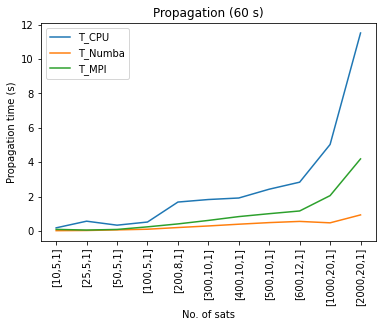

In [ ]:
labels = ['[10,5,1]', '[25,5,1]', '[50,5,1]', '[100,5,1]', '[200,8,1]', '[300,10,1]', '[400,10,1]', '[500,10,1]', '[600,12,1]', '[1000,20,1]', '[2000,20,1]']#,'[3000,20,1]']
x = np.arange(len(conestallations))
plt.plot(x,T_cpu, label = "T_CPU")
plt.xticks(x, labels, rotation ='vertical')
plt.plot(x,T_Numba, label = "T_Numba")
plt.plot(x,T_MPI, label = "T_MPI")
plt.title("Propagation ("+str(tf)+" s)")
plt.xlabel("No. of sats"); plt.ylabel("Propagation time (s)")
plt.legend()
plt.show()

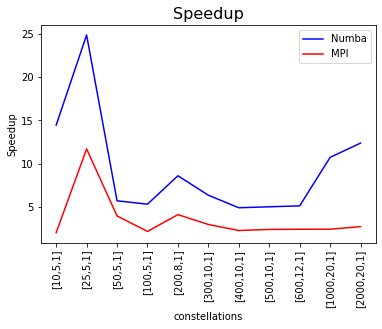

In [ ]:
plt.plot([i / j for i, j in zip(T_cpu, T_Numba)], color='b', label='Numba');
plt.plot([i / j for i, j in zip(T_cpu, list(np.array(T_MPI).T[0]))], color='r', label='MPI');
plt.title("Speedup", size=16); plt.xlabel("constellations"); plt.ylabel("Speedup");
plt.xticks(x, labels, rotation ='vertical')
plt.legend()

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

